# R-VGA for logistic regression

$$
\begin{aligned}
    \mu_t &= \mu_{t-1} + P_{t-1}\left( y_t - \mathbb{E}\left[\sigma(\theta^\intercal{\bf x}_t\right] \right){\bf x}_t\\
    P_{t}^{-1} &= P_{t-1}^{-1} - \mathbb{E}\left[\sigma'\left(\theta^\intercal {\bf x}_t\right)\right]
\end{aligned}
$$

In [1]:
import jax
import chex
import distrax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
mu1 = jnp.array([1.0, -1.0])
mu2 = -mu1

d = len(mu1)

In [4]:
@chex.dataclass
class Params:
    mean: jnp.DeviceArray
    prec: jnp.DeviceArray

In [5]:
key = jax.random.PRNGKey(314)
key_cov, key_data, key_choice = jax.random.split(key, 3)

In [6]:
c = 2.0
n_samp = 100

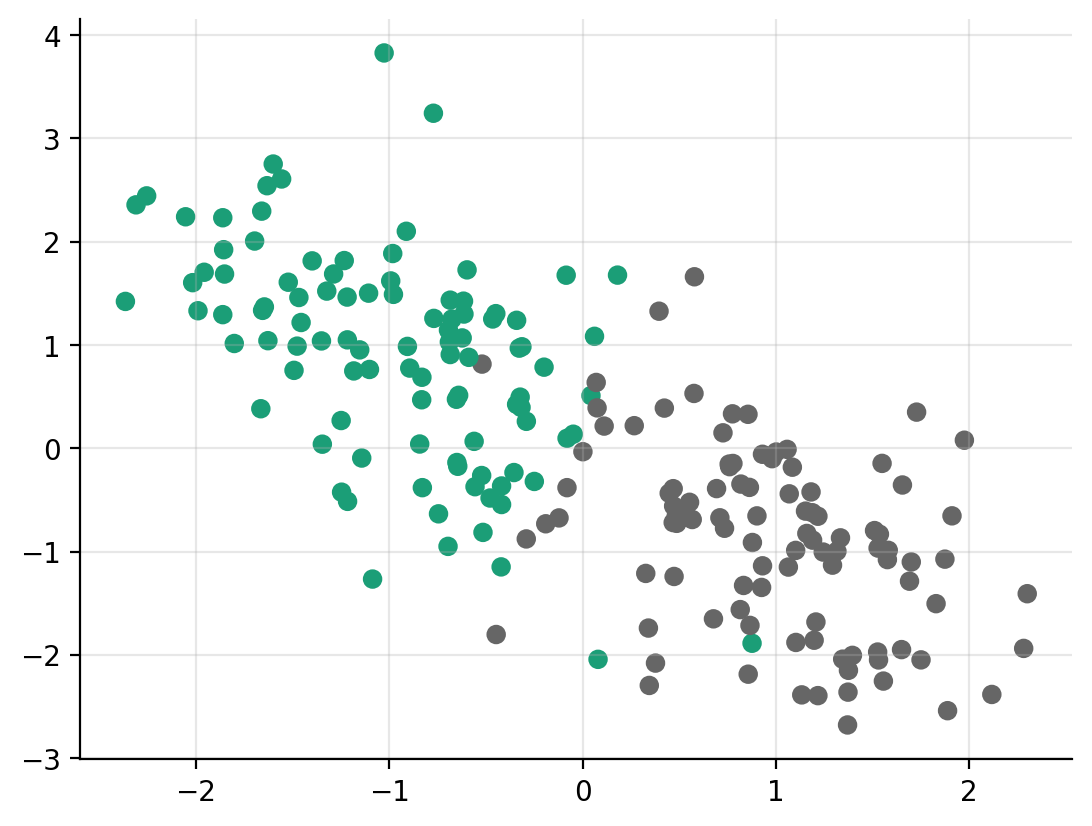

In [7]:
M = jax.random.orthogonal(key_cov, 2)
cov_diag = 1 / jnp.arange(1, d + 1) ** c
cov = jnp.einsum("ji,j,jk->ik", M, cov_diag, M, precision="highest")


X = jax.random.multivariate_normal(key_data, mean=jnp.zeros(d), cov=cov, shape=(2 * n_samp,))

X = X.at[:n_samp].set(X[:n_samp] + mu1)
X = X.at[n_samp:].set(X[n_samp:] + mu2)
y = jnp.append(jnp.ones(n_samp), jnp.zeros(n_samp))

choice = jax.random.choice(key_choice, 2 * n_samp, replace=False, shape=(2 * n_samp,))

X = X[choice]
y = y[choice]
n_obs = len(y)


plt.scatter(*X.T, c=y, cmap="Dark2")
plt.grid(alpha=0.3)

In [8]:
sigma2 = 1.0
mu0 = jnp.zeros(d)
prec0 = jnp.eye(d) / sigma2
params0 = Params(mean=mu0, prec=prec0)

In [9]:
n_samples = 100


def sample_params(key, mu, cov):
    params = distrax.MultivariateNormalFullCovariance(mu, cov).sample(seed=key, sample_shape=(n_samples))
    return params


def sample_pred(params, x):
    """
    Predict the linear term w^T x—
    the input to the logistic
    """
    samples = jnp.einsum("sm,m->s", params, x)
    return samples
    

@jax.jit
def expected_sigmoid(key, x, mu, cov):
    params = sample_params(key, mu, cov)
    x_samps = sample_pred(params, x)
    y_out = jax.nn.sigmoid(x_samps)
    
    return y_out.mean()

@jax.jit
def expected_dsigmoid(key, x, mu, cov):
    params = sample_params(key, mu, cov)
    x_samps = sample_pred(params, x)
    
    y_out = jax.nn.sigmoid(x_samps)
    y_out = y_out * (1 - y_out)
    
    return y_out.mean()

In [84]:
def _rva_inner(i, params, key, x, y):
    key_i = jax.random.fold_in(key, i)
    key_s, key_ds = jax.random.split(key_i, 2)
    
    mean = params.mean
    prec = params.prec
    cov = jnp.linalg.inv(prec)
    
    e_sigmoid = expected_sigmoid(key_s, x, mean, cov)
    e_dsigmoid = expected_dsigmoid(key_ds, x, mean, cov)
    
    mean = mean + cov @ x * (y - e_sigmoid)
    prec = prec + jnp.einsum("i,j->ij", x, x) * e_dsigmoid
    
    params = params.replace(
        mean=mean,
        prec=prec
    )
    
    return params

In [85]:
@partial(jax.jit, static_argnames=("n_iter",))
def rvga_step(params, data, n_iter):
    key, x, y = data
    
    _inner = partial(_rva_inner, x=x, y=y, key=key)
    params = jax.lax.fori_loop(0, n_iter, _inner, params)
    return params, params

In [86]:
keys = jax.random.split(key, n_obs)
xs = (keys, X, y)

xs_init = jax.tree_map(lambda x: x[0], xs)

In [88]:
bel, hist = jax.lax.scan(
    partial(rvga_step, n_iter=1),
    params0,
    xs
)

In [92]:
hist_cov = jax.vmap(jnp.linalg.inv)(hist.prec)
hist_cov.shape

(200, 2, 2)

In [94]:
yhat = jax.vmap(expected_sigmoid, (None, 0, 0, 0))(key, X, hist.mean, hist_cov)

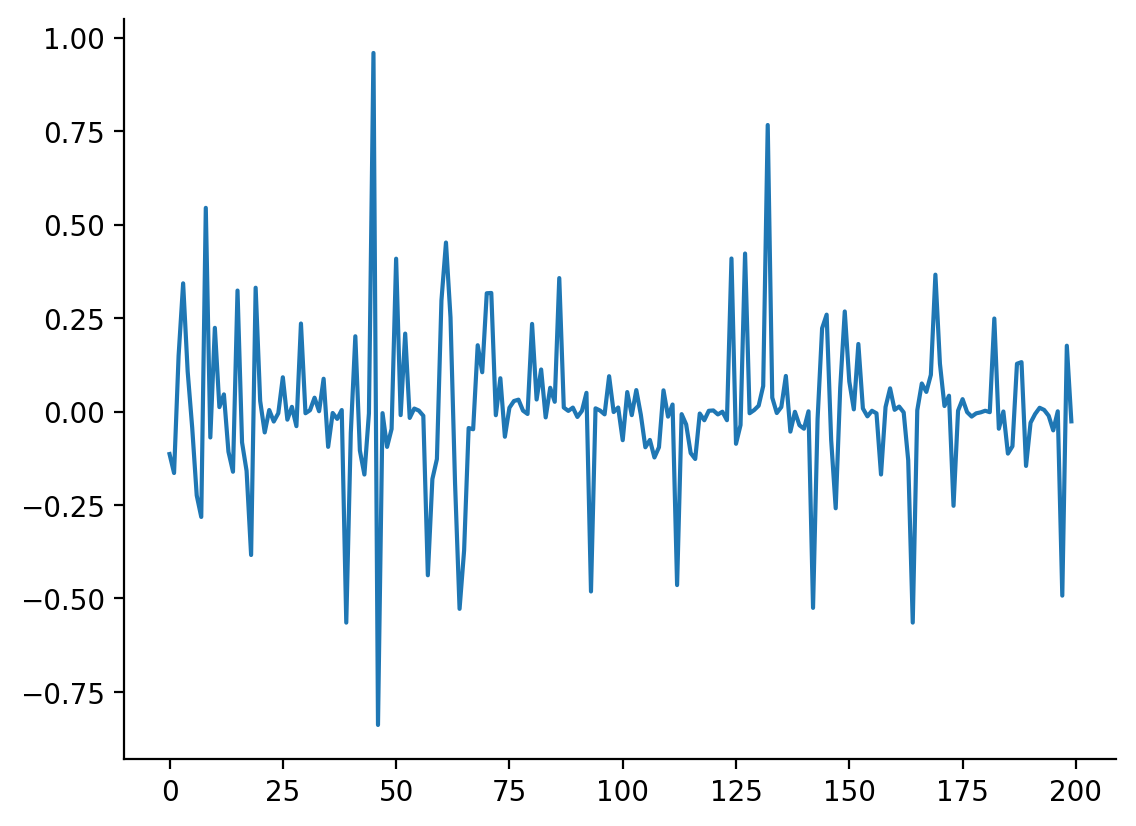

In [97]:
plt.plot(yhat - y)

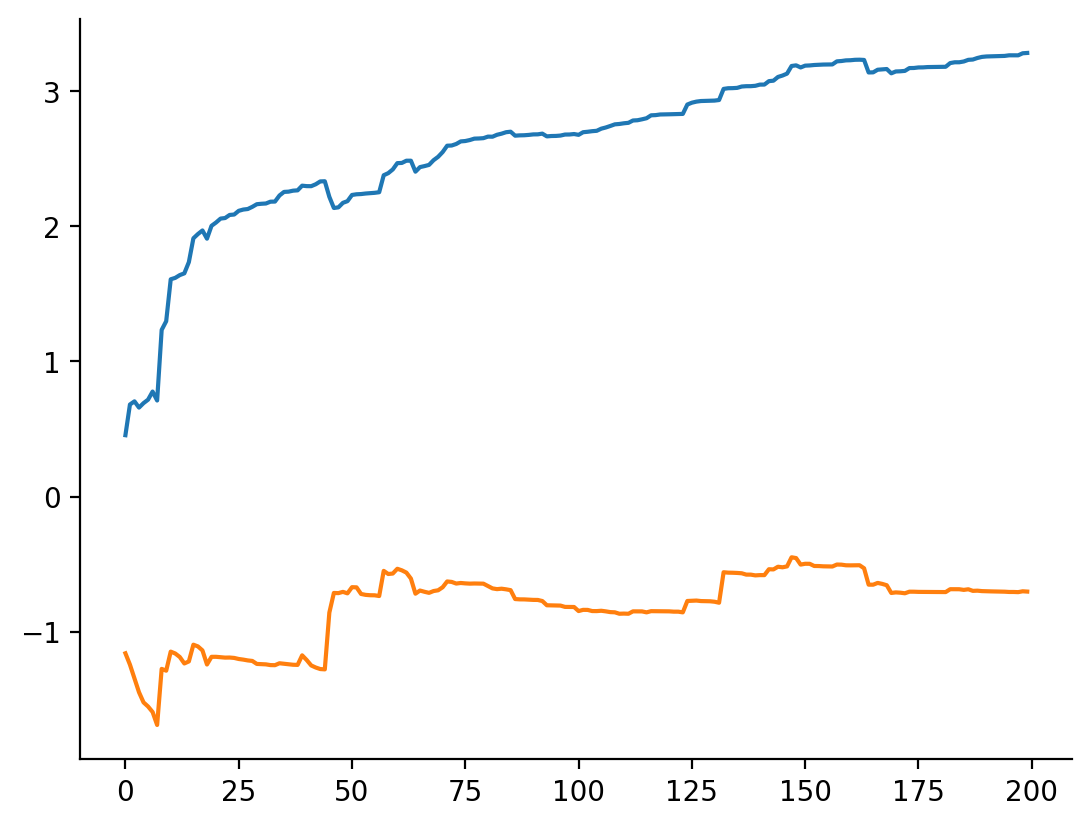

In [90]:
plt.plot(hist.mean)

# R-VGA for logistic regression

$$
\begin{aligned}
    \mu_t &= \mu_{t-1} + P_{t-1}\left( y_t - \mathbb{E}\left[\sigma(\theta^\intercal{\bf x}_t\right] \right){\bf x}_t\\
    P_{t}^{-1} &= P_{t-1}^{-1} - \mathbb{E}\left[\sigma'\left(\theta^\intercal {\bf x}_t\right)\right] x_tx_t^\intercal
\end{aligned}
$$